In [ ]:
from google.colab import files
import io

uploaded = files.upload()
for fn in uploaded.keys():
    print(r'User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving loan_repayment_status_final_v2.csv to loan_repayment_status_final_v2.csv
User uploaded file "loan_repayment_status_final_v2.csv" with length 112395 bytes


Successfully loaded data from 'loan_repayment_status_final_v2.csv' into a DataFrame.
--- Data Preprocessing ---
Label encoded column: finance_app_usage
Converted 'loan_repayment_status' to binary classes (0 or 1).
Data split into training (80%) and testing (20%) sets.
X_train shape: (1600, 14), y_train shape: (1600,)
X_test shape: (400, 14), y_test shape: (400,)
Numerical features scaled using StandardScaler.
Scaler saved successfully as scaler.pkl

--- XGBoost Model Training ---
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.8}
XGBoost model trained successfully.

--- Model Evaluation ---
ROC AUC: 0.9790

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       194
           1       0.94      0.92      0.93       206

    accuracy                        

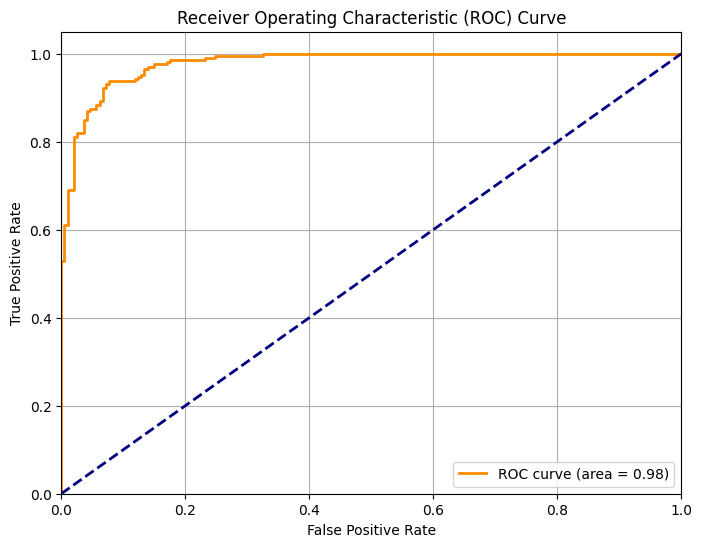

ROC Curve displayed.


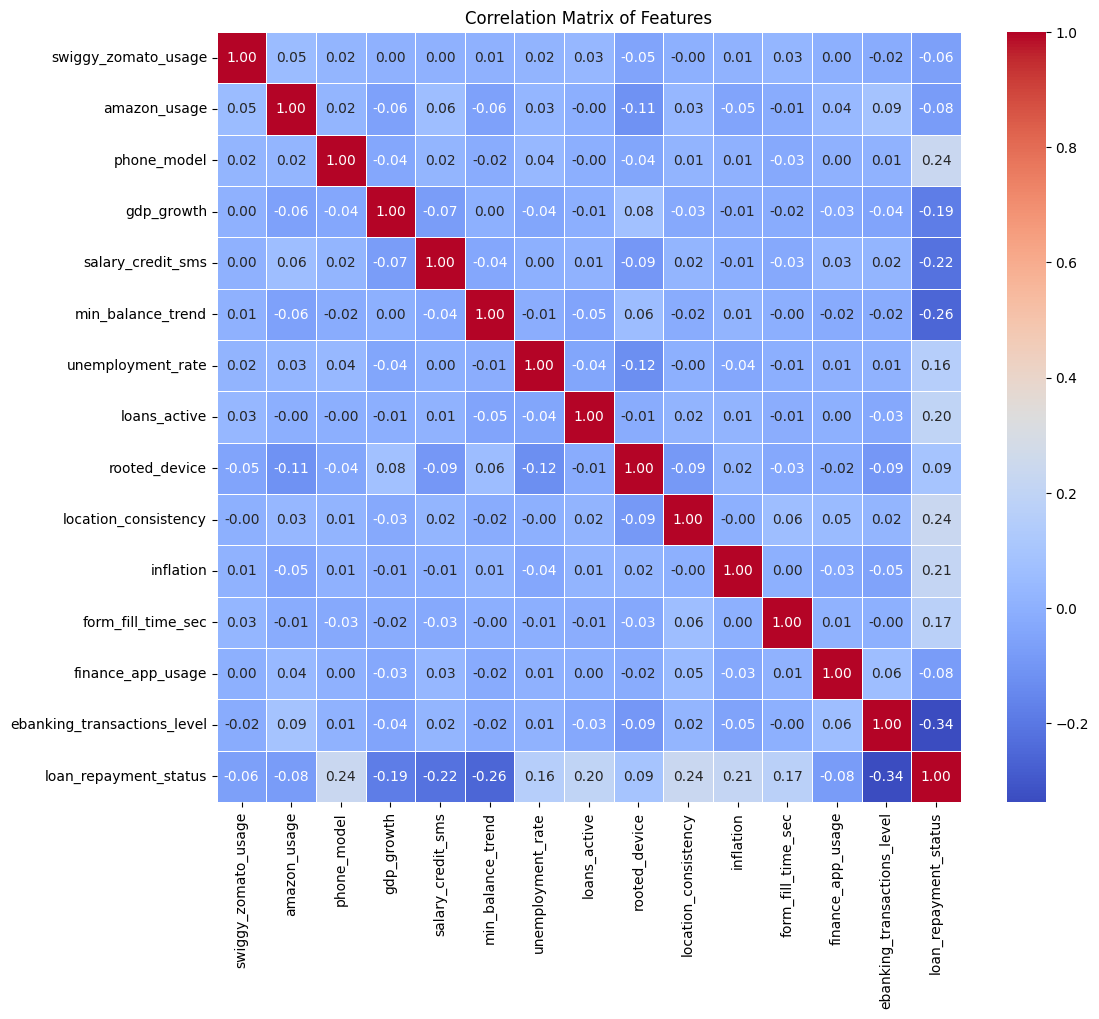

Correlation Matrix displayed.

--- SHAP Value Analysis ---


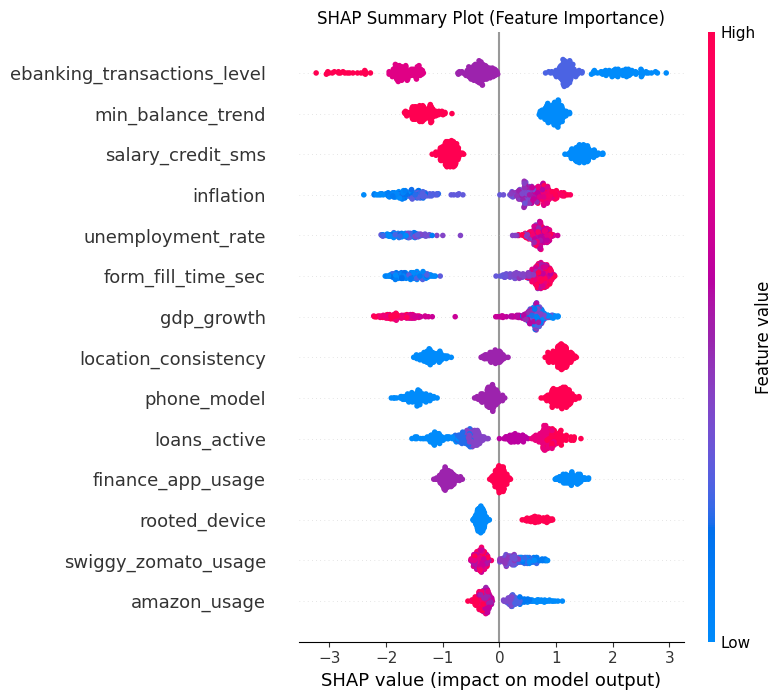

SHAP Summary Plot (beeswarm) displayed.


<Figure size 800x600 with 0 Axes>

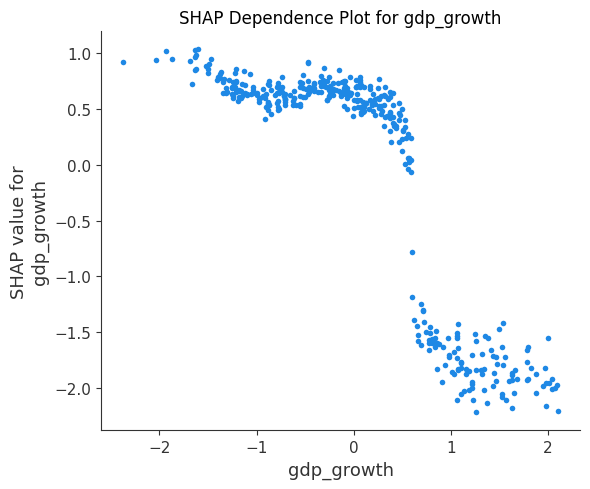

SHAP Dependence Plot for 'gdp_growth' displayed.

SHAP Force Plot for a single prediction:


SHAP Force Plot for sample 0 displayed (interactive in Jupyter/Colab).

--- Script Finished ---

--- Predicted Probability of Default for Test Set Instances ---
      Original_Index  Actual_Default_Status  Predicted_Probability_of_Default
534              534                      0                          0.042761
874              874                      0                          0.007092
1177            1177                      1                          0.999353
242              242                      0                          0.000456
1338            1338                      0                          0.035699
1610            1610                      1                          0.973104
140              140                      1                          0.982550
1706            1706                      0                          0.006406
1125            1125                      0                          0.177530
1009            1009                      1                

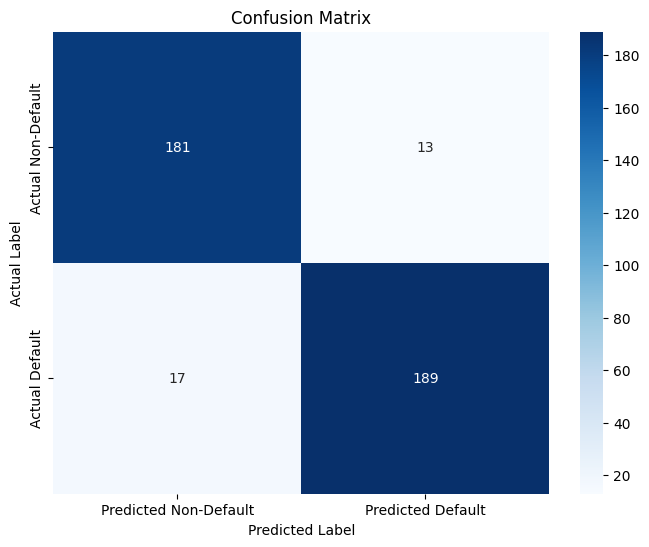

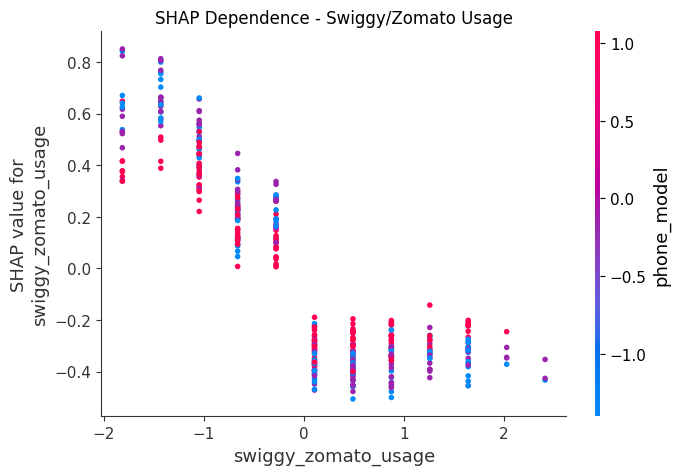

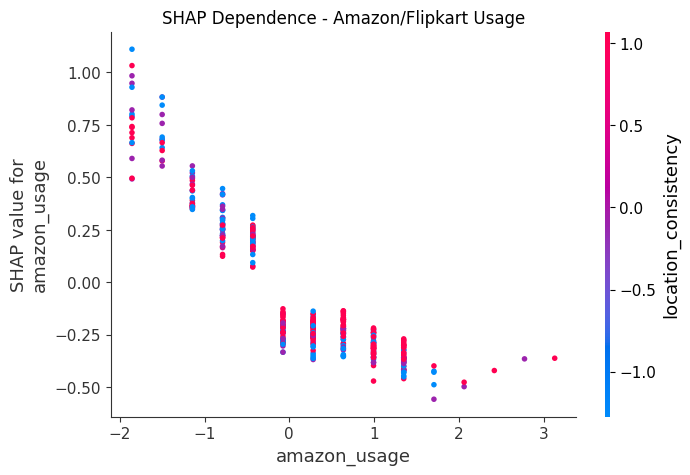

Feature Importance Plots  



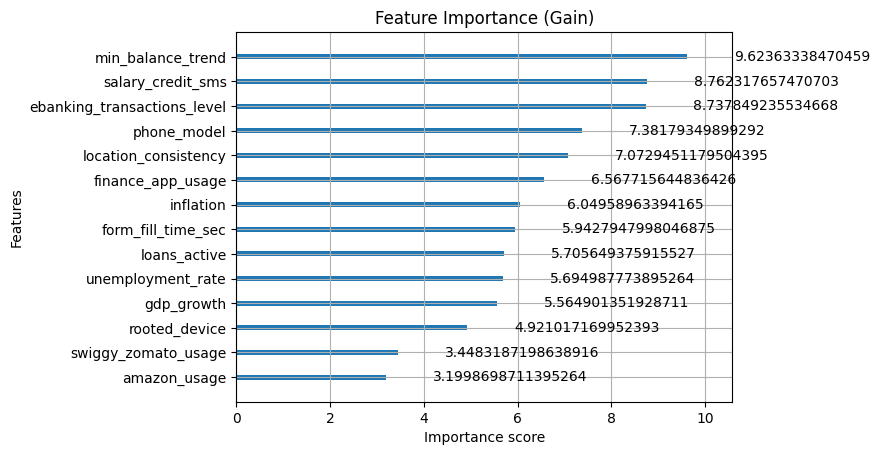

 Partial Dependence Plots (PDP) 



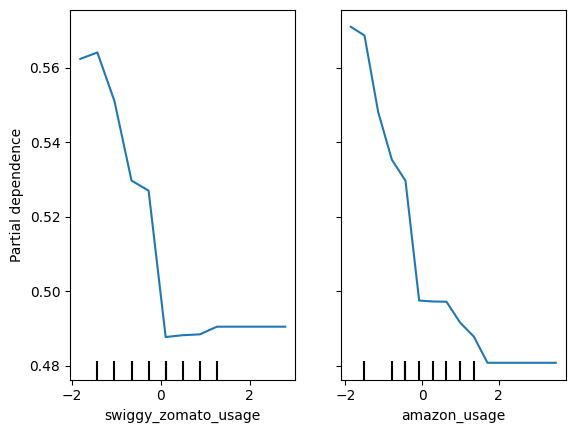

Permutation Feature Importance  



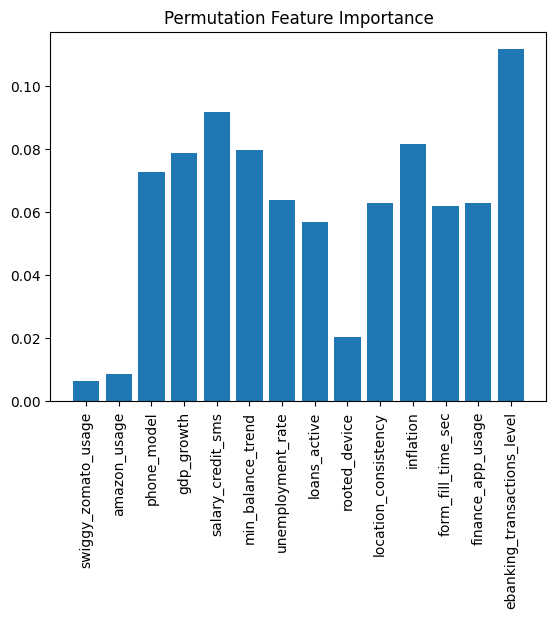

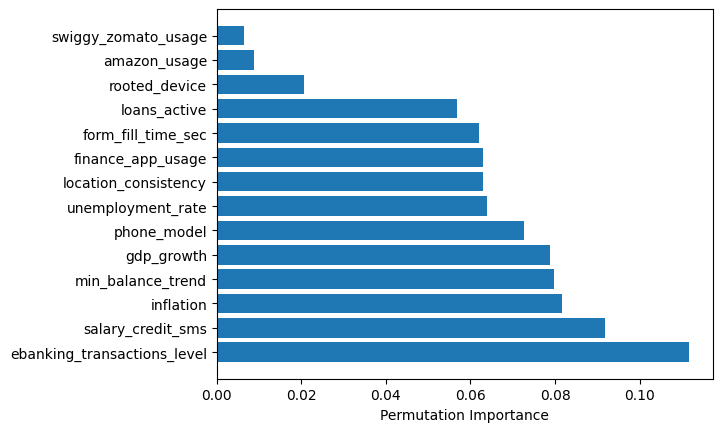

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold
 # Import joblib to save the scaler
from sklearn.inspection import PartialDependenceDisplay # Import PartialDependenceDisplay

warnings.filterwarnings('ignore')

# Load the dataset
try:
    # Assuming only one file is uploaded and its name is in the uploaded dictionary keys
    if uploaded:
        # Get the first filename from the uploaded dictionary
        filename = list(uploaded.keys())[0]
        # Read the uploaded file content into a pandas DataFrame
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
        print(f"Successfully loaded data from '{filename}' into a DataFrame.")
    else:
        print("Error: No file was uploaded.")
        df = None
except Exception as e:
    print(f"Error loading the dataset: {e}")
    df = None

# --- Preprocessing ---
print("--- Data Preprocessing ---")

if df is not None: # Proceed only if df was loaded successfully
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=np.number).columns



    # Apply Label Encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"Label encoded column: {col}")

    # Convert the continuous target variable into binary classes
    # For example, classify as 1 if loan_repayment_status >= 0.5, else 0
    df['loan_repayment_status'] = (df['loan_repayment_status'] >= 0.5).astype(int)
    print("Converted 'loan_repayment_status' to binary classes (0 or 1).")


    # Define features (X) and target (y)
    X = df.drop('loan_repayment_status', axis=1)
    y = df['loan_repayment_status']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Data split into training (80%) and testing (20%) sets.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Scale numerical features (optional, but good practice for some models, though less critical for tree-based models)
    scaler = StandardScaler()
    # Fit the scaler only on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train[numerical_cols.drop('loan_repayment_status', errors='ignore')])
    X_test_scaled = scaler.transform(X_test[numerical_cols.drop('loan_repayment_status', errors='ignore')])

    # Replace the original numerical columns with scaled ones in the DataFrames
    X_train[numerical_cols.drop('loan_repayment_status', errors='ignore')] = X_train_scaled
    X_test[numerical_cols.drop('loan_repayment_status', errors='ignore')] = X_test_scaled

    print("Numerical features scaled using StandardScaler.")

    # Save the scaler
    joblib.dump(scaler, "scaler.pkl")
    print("Scaler saved successfully as scaler.pkl")


    # --- XGBoost Model Training ---
    print("\n--- XGBoost Model Training ---")

    # Initialize XGBoost Classifier
    # Parameters can be tuned for better performance
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'scale_pos_weight': [1.0]
    }

    # Set up XGBoost model
    xgb_base = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    )

    # Set up stratified 3-fold cross-validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_base,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=cv,
                           verbose=1)

    # Fit on training data
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    print("Best parameters found:")
    print(grid_search.best_params_)

    # Use the best model found by GridSearchCV
    model = best_model

    # Train the model (this step is redundant after GridSearchCV, but kept for clarity)
    # Use the scaled training data for model training
    # model.fit(X_train, y_train) # Not needed if using best_model from GridSearchCV
    print("XGBoost model trained successfully.")

    # --- Model Evaluation ---
    print("\n--- Model Evaluation ---")

    # Make predictions on the test set
    # Use the scaled testing data for prediction
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class
    y_pred = model.predict(X_test)                   # Predicted classes

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # --- Visualization ---

    # 1. ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print("ROC Curve displayed.")

    # 2. Correlation Matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Features')
    plt.show()
    print("Correlation Matrix displayed.")

    # 3. SHAP Values
    print("\n--- SHAP Value Analysis ---")
    # Create a SHAP explainer object
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the test set
    # Use the scaled test data for SHAP
    shap_values = explainer.shap_values(X_test)

    # SHAP Summary Plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
    plt.title('SHAP Summary Plot (Feature Importance)')
    plt.tight_layout()
    plt.show()
    print("SHAP Summary Plot (beeswarm) displayed.")


    # SHAP Dependence Plot for a specific feature (e.g., 'gdp_growth')
    # Choose a feature to visualize its impact
    feature_to_plot = 'gdp_growth'
    if feature_to_plot in X_test.columns:
        plt.figure(figsize=(8, 6))
        # Use the scaled test data for SHAP dependence plot
        shap.dependence_plot(feature_to_plot, shap_values, X_test, interaction_index=None, show=False)
        plt.title(f'SHAP Dependence Plot for {feature_to_plot}')
        plt.tight_layout()
        plt.show()
        print(f"SHAP Dependence Plot for '{feature_to_plot}' displayed.")
    else:
        print(f"Feature '{feature_to_plot}' not found in X_test for dependence plot.")

    # SHAP Force Plot for a single prediction (e.g., the first instance in the test set)
    print("\nSHAP Force Plot for a single prediction:")
    shap.initjs() # Initialize JavaScript for interactive plots
    # For binary classification, shap_values will be a list of two arrays (for class 0 and class 1)
    # We usually look at the shap values for the positive class (class 1)
    sample_index = 0
    if isinstance(shap_values, list) and len(shap_values) == 2: # Check if it's a multi-output explainer (binary classification)
        # Use the scaled test data for force plot
        display(shap.force_plot(explainer.expected_value[1], shap_values[1][sample_index,:], X_test.iloc[sample_index,:]))
    else: # Single output explainer (regression or single class classification)
        # Use the scaled test data for force plot
        display(shap.force_plot(explainer.expected_value, shap_values[sample_index,:], X_test.iloc[sample_index,:]))
    print(f"SHAP Force Plot for sample {sample_index} displayed (interactive in Jupyter/Colab).")

    print("\n--- Script Finished ---")

else:
    print("Script aborted due to an error during file loading.")


print("\n--- Predicted Probability of Default for Test Set Instances ---")
probability_df = pd.DataFrame({
    'Original_Index': X_test.index,
    'Actual_Default_Status': y_test,
    'Predicted_Probability_of_Default': y_pred_proba
})
print(probability_df.head(10))
print(f"\nTotal {len(probability_df)} predictions generated.")
print("You can access the full 'probability_df' for all test set predictions.")


# Confusion Matrix Analysis
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Default', 'Predicted Default'],
            yticklabels=['Actual Non-Default', 'Actual Default'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Swiggy/Zomato usage dependence plot
shap.dependence_plot(
    "swiggy_zomato_usage", shap_values, X_test, show=False
)
plt.title("SHAP Dependence - Swiggy/Zomato Usage")
plt.show()

# Amazon/Flipkart usage dependence plot
shap.dependence_plot(
    "amazon_usage", shap_values, X_test, show=False
)
plt.title("SHAP Dependence - Amazon/Flipkart Usage")
plt.show()




print(" Partial Dependence Plots (PDP) \n")
# Use PartialDependenceDisplay for plotting partial dependence
PartialDependenceDisplay.from_estimator(model, X_train, ['swiggy_zomato_usage', 'amazon_usage'])
plt.show()


from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by="Importance", ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Permutation Importance")
plt.show()


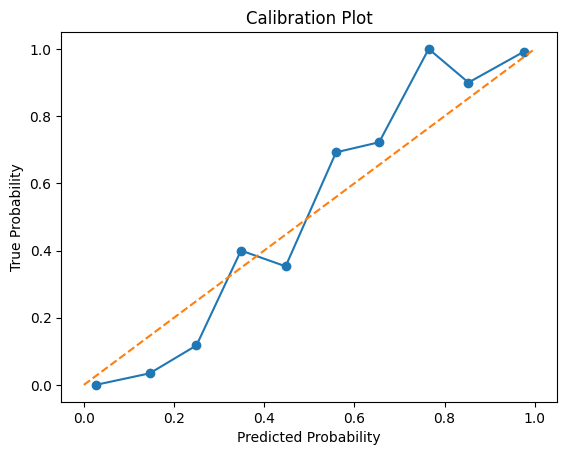

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], '--')  # perfect calibration line
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Plot")
plt.show()


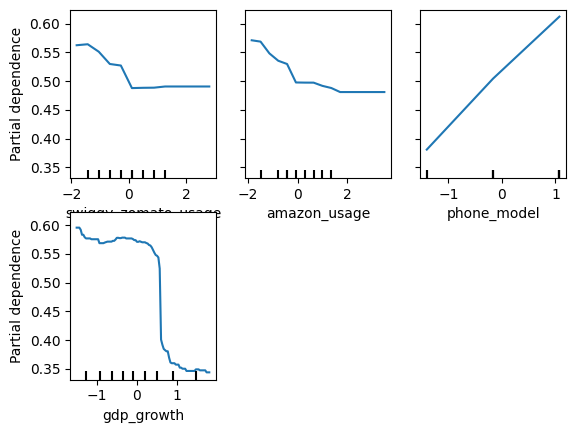

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = [0, 1, 2,3]
PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_train,
    features=features_to_plot,
    kind="average"
)
plt.show()

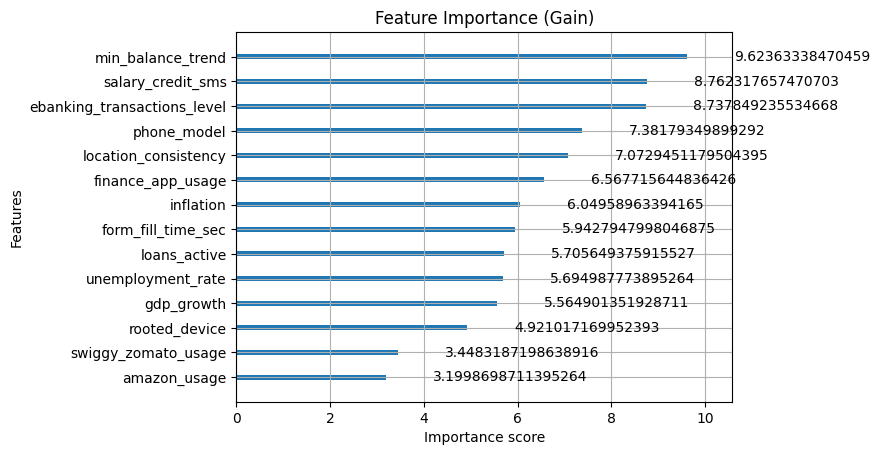

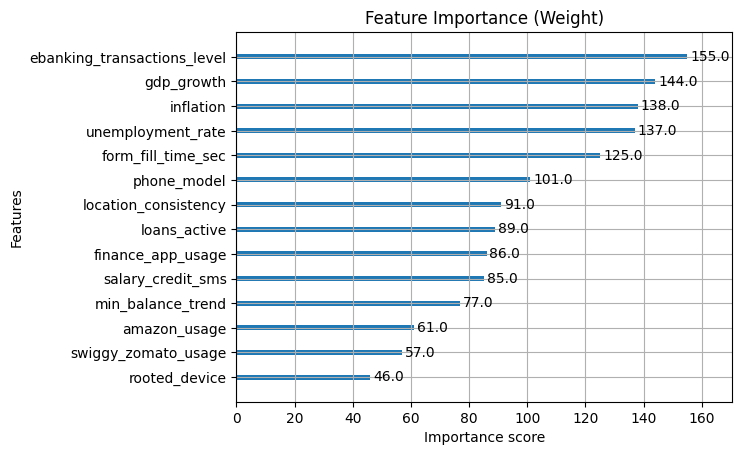

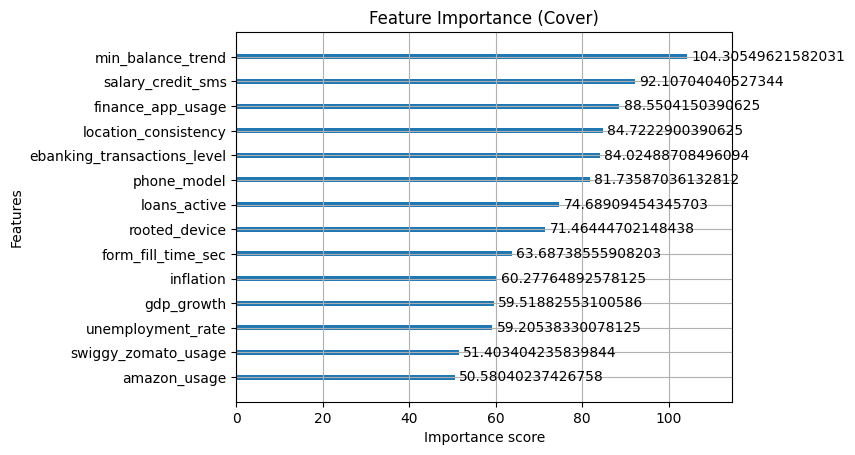

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming your trained model is 'model'
xgb.plot_importance(model, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance (Weight)")
plt.show()

xgb.plot_importance(model, importance_type='cover')
plt.title("Feature Importance (Cover)")
plt.show()


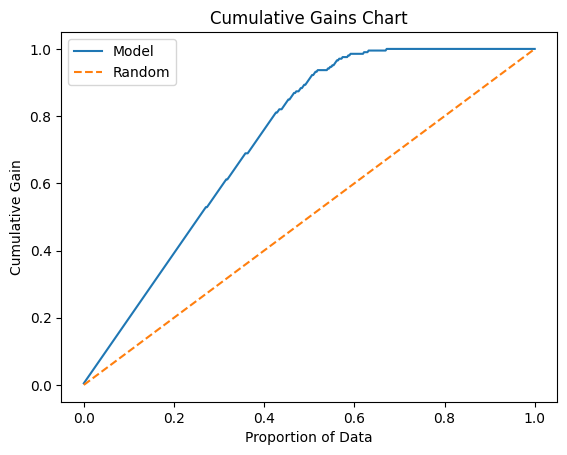

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Sort by predicted probability
sorted_idx = np.argsort(y_pred_proba)[::-1]
y_sorted = y_test.iloc[sorted_idx]

cumulative_gains = np.cumsum(y_sorted) / sum(y_sorted)
plt.plot(np.linspace(0, 1, len(cumulative_gains)), cumulative_gains, label="Model")
plt.plot([0, 1], [0, 1], '--', label="Random")
plt.xlabel("Proportion of Data")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.show()


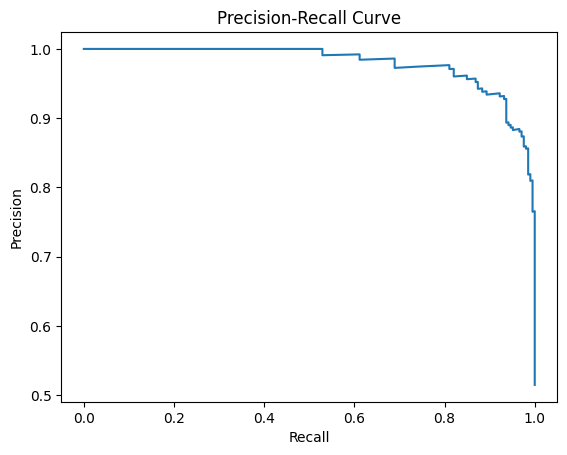

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [ ]:
booster = model.get_booster()
booster.feature_names = list(X_train.columns)
print(booster.trees_to_dataframe().head())  # Tree splits & conditions


   Tree  Node   ID                      Feature     Split  Yes    No Missing  \
0     0     0  0-0  ebanking_transactions_level  0.228789  0-1   0-2     0-2   
1     0     1  0-1                   gdp_growth  0.618587  0-3   0-4     0-4   
2     0     2  0-2            min_balance_trend  1.194957  0-5   0-6     0-6   
3     0     3  0-3         location_consistency -0.102422  0-7   0-8     0-8   
4     0     4  0-4            salary_credit_sms  0.765329  0-9  0-10    0-10   

         Gain       Cover  Category  
0  106.822556  318.463135       NaN  
1   39.960812  129.383453       NaN  
2   52.619366  189.079681       NaN  
3   23.296692   90.918106       NaN  
4   21.866468   38.465351       NaN  


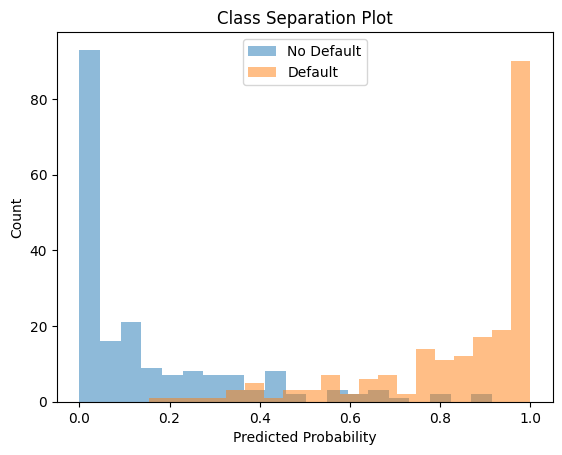

In [ ]:
plt.hist(y_pred_proba[y_test==0], bins=20, alpha=0.5, label="No Default")
plt.hist(y_pred_proba[y_test==1], bins=20, alpha=0.5, label="Default")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Class Separation Plot")
plt.legend()
plt.show()


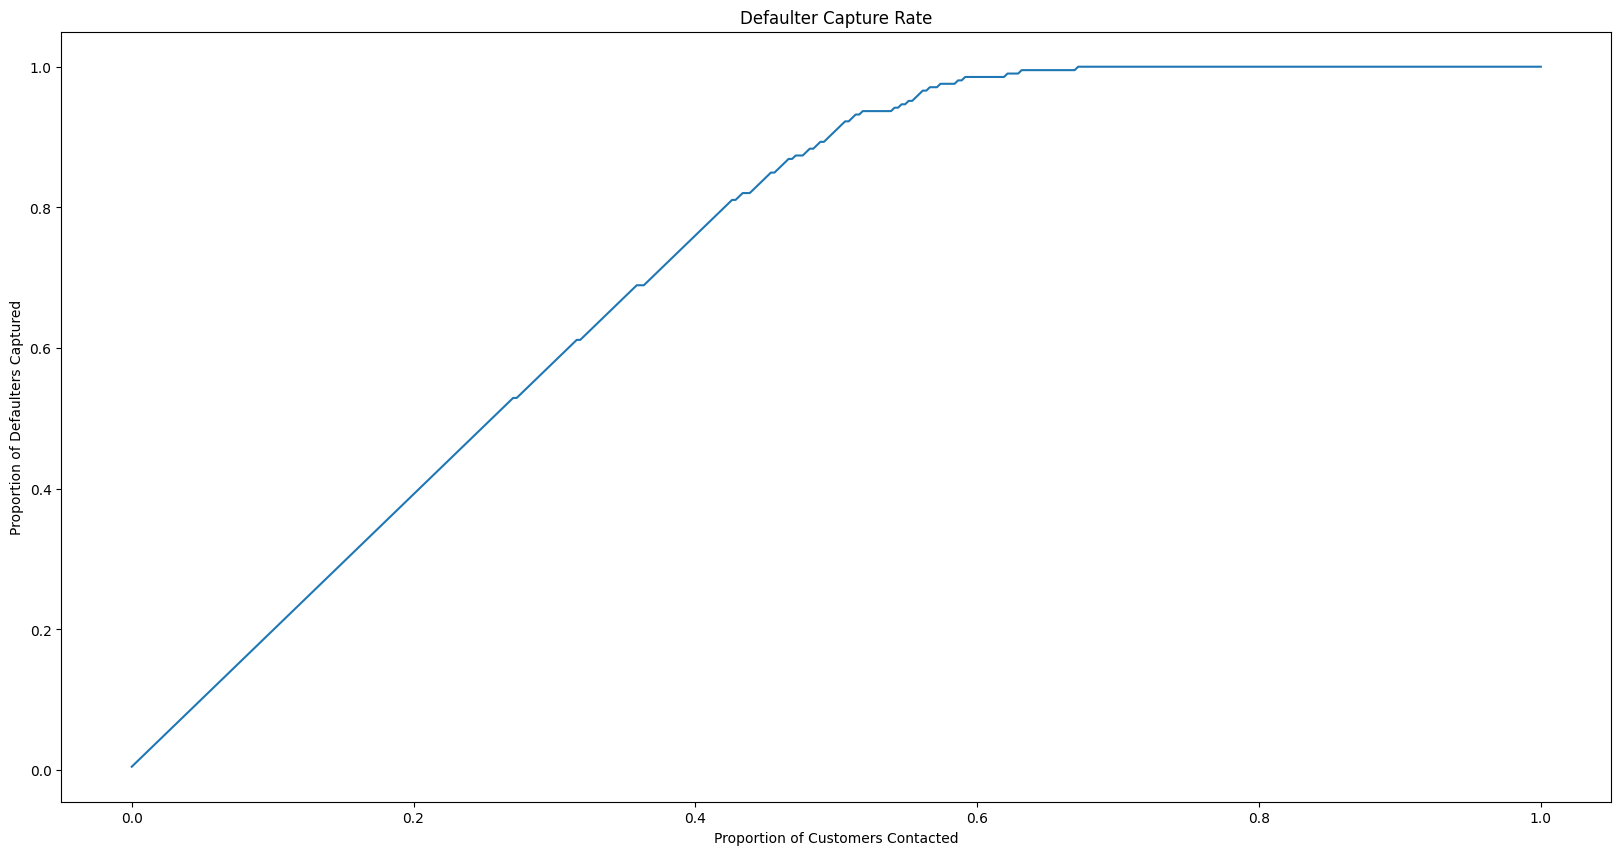

In [ ]:
df_results = pd.DataFrame({"prob": y_pred_proba, "actual": y_test})
df_results = df_results.sort_values("prob", ascending=False)
df_results["cum_defaulters"] = np.cumsum(df_results["actual"]) / df_results["actual"].sum()
plt.plot(np.linspace(0, 1, len(df_results)), df_results["cum_defaulters"])
plt.xlabel("Proportion of Customers Contacted")
plt.ylabel("Proportion of Defaulters Captured")
plt.title("Defaulter Capture Rate")
plt.show()


In [ ]:
from sklearn.metrics import brier_score_loss
import numpy as np

# =======================
# 8. Brier Score
# =======================
brier = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier:.4f} (Lower is better)")

# =======================
# 9. Expected Calibration Error (ECE)
# =======================
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        if np.any(bin_mask):
            avg_confidence = y_prob[bin_mask].mean()
            avg_accuracy = y_true[bin_mask].mean()
            bin_weight = bin_mask.sum() / len(y_true)
            ece += np.abs(avg_confidence - avg_accuracy) * bin_weight
    return ece

ece_score = expected_calibration_error(y_test.values, y_pred_proba, n_bins=10)
print(f"Expected Calibration Error (ECE): {ece_score:.4f} (Lower is better)")


Brier Score: 0.0604 (Lower is better)
Expected Calibration Error (ECE): 0.0563 (Lower is better)


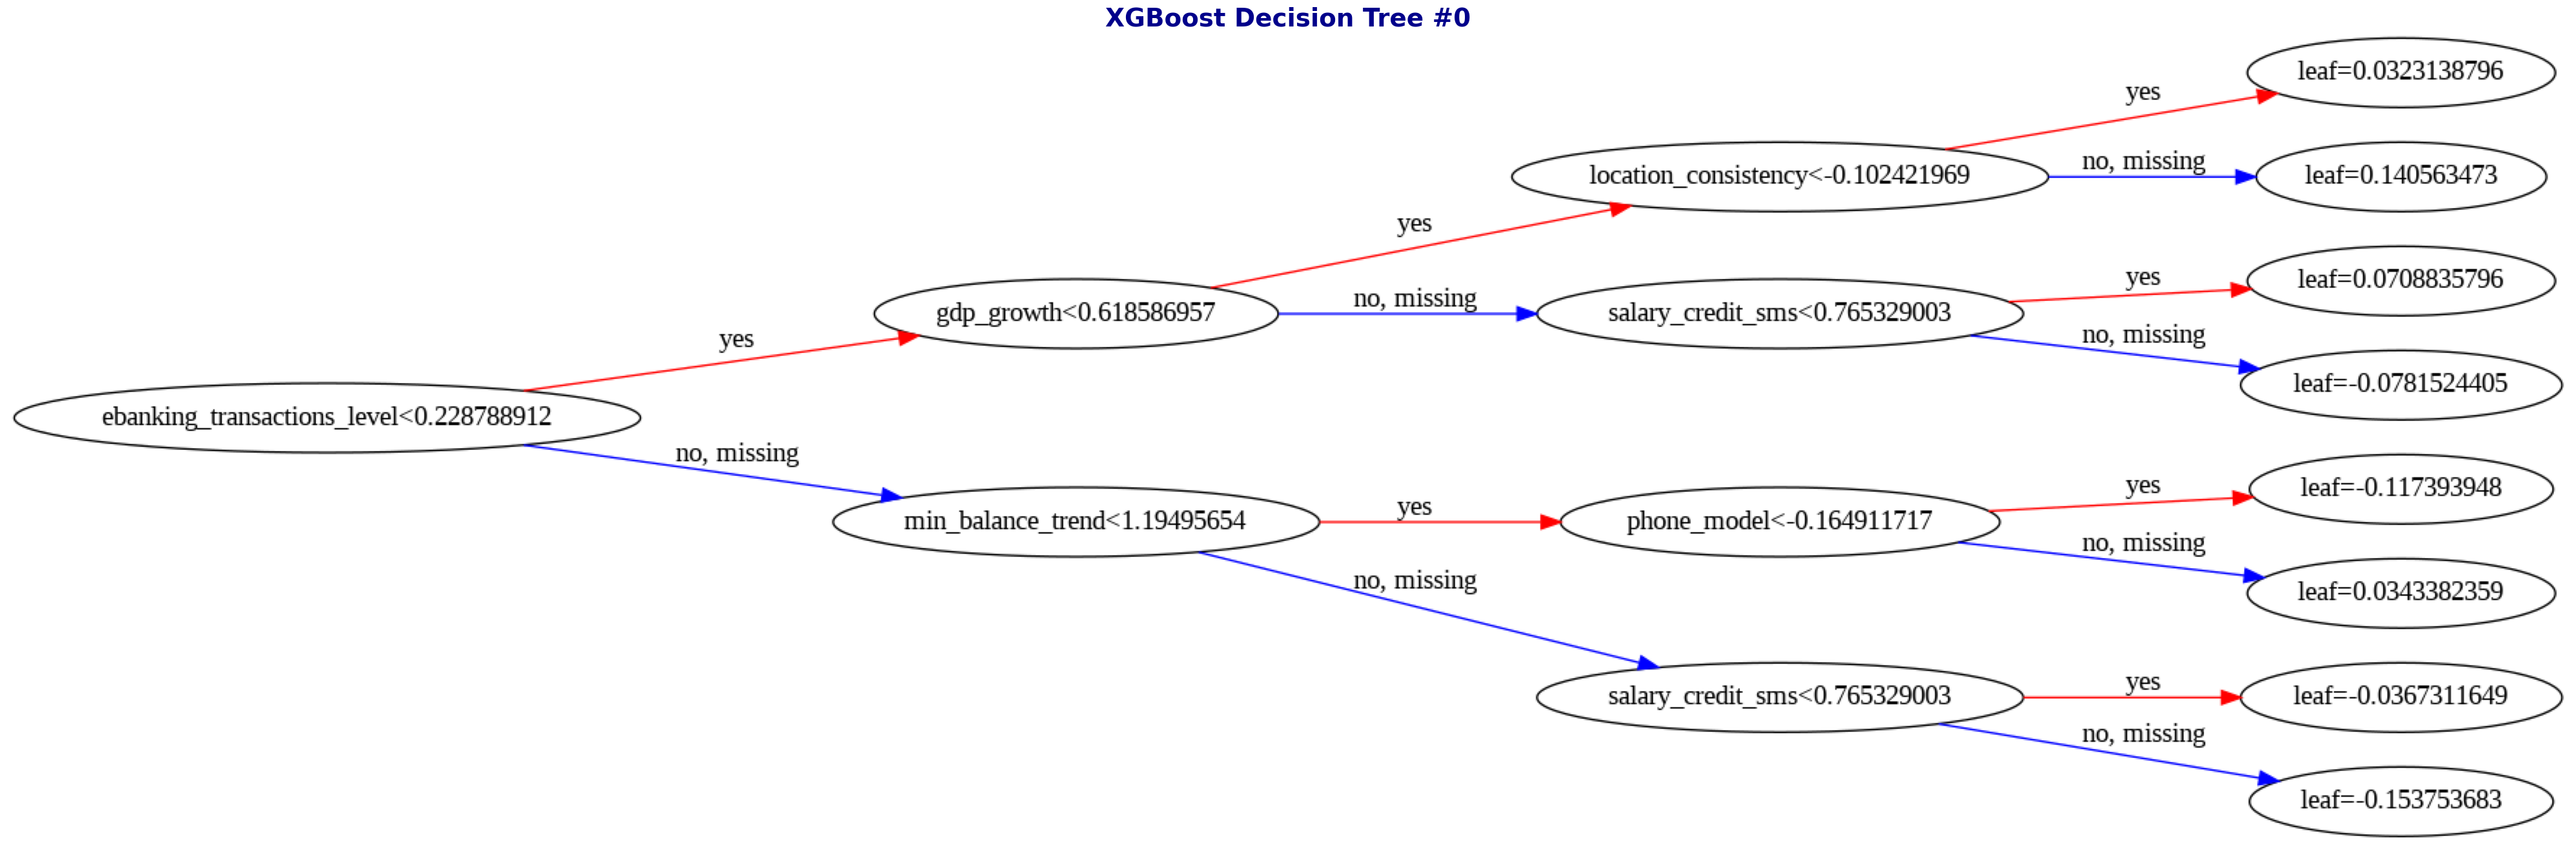

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Choose which tree to plot (0 = first tree)
tree_num = 0

# Create large figure for readability
fig, ax = plt.subplots(figsize=(40, 20))

# Plot the tree with left-to-right layout and filled colors
plot_tree(
    model,
    num_trees=tree_num,
    rankdir='LR',       # Left to Right layout
    ax=ax
)

# Style tweaks
plt.title(f"XGBoost Decision Tree #{tree_num}", fontsize=28, fontweight='bold', color='darkblue')
plt.axis('off')  # Hide the axes

# Add a tight layout so nothing gets cut off
plt.tight_layout()

# Show the plot
plt.show()







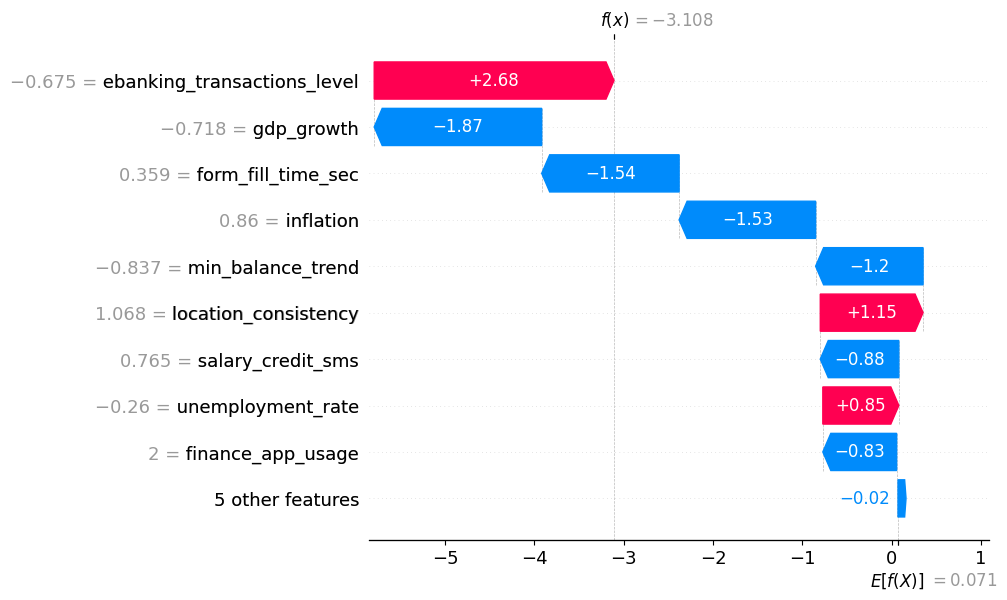

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                     base_values=explainer.expected_value,
                                     data=X_train.iloc[0]))



Successfully loaded original data from 'loan_repayment_status_final_v2.csv' into orig_df.
Successfully created probability_df.
Successfully merged probability_df and original data.


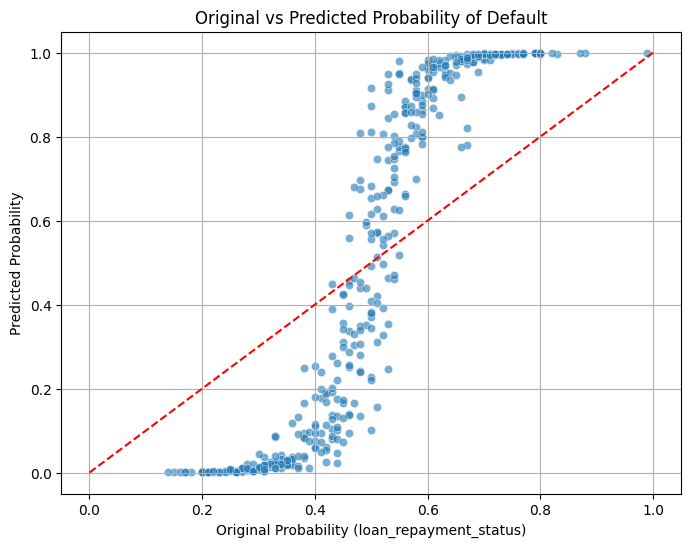

Scatter plot displayed.


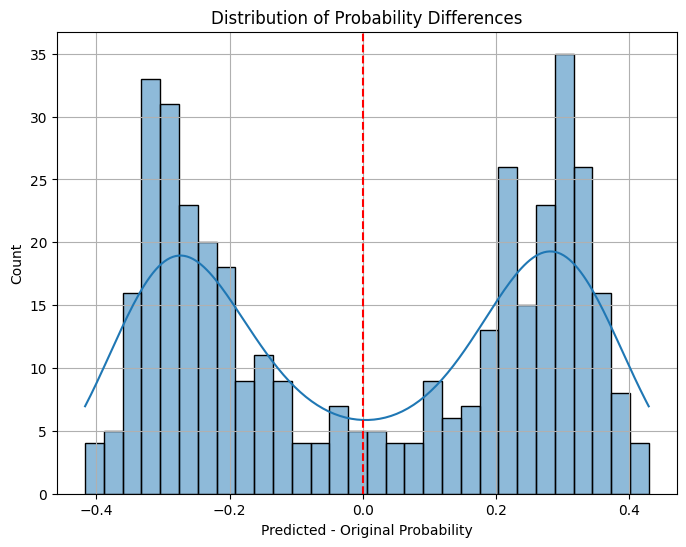

Histogram of differences displayed.
Correlation between original and predicted probabilities: 0.9079


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load original dataset
# Assuming the uploaded file name is available from the previous cell's `uploaded` dictionary
if 'uploaded' in locals() and uploaded:
    filename = list(uploaded.keys())[0]
    # Read the uploaded file content into a pandas DataFrame
    try:
        orig_df = pd.read_csv(io.BytesIO(uploaded[filename]))
        print(f"Successfully loaded original data from '{filename}' into orig_df.")
    except Exception as e:
        print(f"Error loading the original dataset: {e}")
        orig_df = None
else:
    print("Error: Original file not uploaded or 'uploaded' variable not found.")
    orig_df = None


if orig_df is not None:
    # Your predictions dataframe should have:
    #   - 'Original_Index'
    #   - 'Predicted_Probability_of_Default'
    # Replace this line with your real probability_df
    # Example:
    # probability_df = pd.read_csv("predictions.csv")

    # Recreate probability_df in this cell to ensure it's available
    try:
        probability_df = pd.DataFrame({
            "Original_Index": X_test.index,
            "Actual_Default_Status": y_test,
            "Predicted_Probability_of_Default": model.predict_proba(X_test)[:,1]
        })
        print("Successfully created probability_df.")
    except NameError:
        print("Error: X_test or model not defined. Please ensure previous cells were executed.")
        probability_df = None


    if probability_df is not None:
        # Reset index of orig_df to make the original index a column
        orig_df_reset = orig_df.reset_index()
        # Rename the index column to 'Original_Index' to match probability_df
        orig_df_reset = orig_df_reset.rename(columns={'index': 'Original_Index'})

        # Merge predictions with original probabilities
        merged = probability_df.merge(
            orig_df_reset[['Original_Index', 'loan_repayment_status']],
            on='Original_Index',
            how='left'
        )
        print("Successfully merged probability_df and original data.")

        # Calculate differences
        merged['difference'] = merged['Predicted_Probability_of_Default'] - merged['loan_repayment_status']

        # Scatter plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x='loan_repayment_status',
            y='Predicted_Probability_of_Default',
            data=merged,
            alpha=0.6
        )
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # perfect match line
        plt.xlabel("Original Probability (loan_repayment_status)")
        plt.ylabel("Predicted Probability")
        plt.title("Original vs Predicted Probability of Default")
        plt.grid(True)
        plt.show()
        print("Scatter plot displayed.")


        # Histogram of differences
        plt.figure(figsize=(8, 6))
        sns.histplot(merged['difference'], bins=30, kde=True)
        plt.axvline(0, color='red', linestyle='--')
        plt.xlabel("Predicted - Original Probability")
        plt.ylabel("Count")
        plt.title("Distribution of Probability Differences")
        plt.grid(True)
        plt.show()
        print("Histogram of differences displayed.")

        # Correlation
        correlation = merged['loan_repayment_status'].corr(merged['Predicted_Probability_of_Default'])
        print(f"Correlation between original and predicted probabilities: {correlation:.4f}")
    else:
        print("Skipping visualization and correlation calculation due to missing probability_df.")
else:
    print("Skipping data processing, visualization, and correlation calculation due to missing orig_df.")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import joblib
# Ensure the model training cell (amq8bC_dwVya) has been executed before running this cell.
# If the model was trained successfully, the 'model' variable should be available.
try:
    joblib.dump(model, "credit_model.pkl")
    print("Model saved successfully as credit_model.pkl")
except NameError:
    print("Error: 'model' is not defined. Please ensure the model training cell was executed.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Model saved successfully as credit_model.pkl


In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load the saved model and scaler
model = joblib.load("credit_model.pkl")
scaler = joblib.load("scaler.pkl")

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Parse input JSON data
        data = request.json

        # Extract features from input data
        features = np.array(data['features']).reshape(1, -1)

        # Standardize the input features
        scaled_features = scaler.transform(features)

        # Predict probability of default
        probability = model.predict_proba(scaled_features)[:, 1][0]

        # Determine risk level
        risk = "High Risk" if probability > 0.5 else "Low Risk"

        return jsonify({"probability_of_default": probability, "risk_level": risk})

    except Exception as e:
        return jsonify({"error": str(e)})

In [ ]:
import numpy as np
import joblib

# Load model and scaler
model = joblib.load("credit_model.pkl")
scaler = joblib.load("scaler.pkl")

# Define sample input in the same order as the features used for training (14 features)
# Example: [swiggy_zomato_usage, amazon_usage, phone_model, gdp_growth, salary_credit_sms,
#           min_balance_trend, unemployment_rate, loans_active, rooted_device,
#           location_consistency, inflation, form_fill_time_sec, finance_app_usage,
#           ebanking_transactions_level] - this should match the columns in X used for training
sample_data = np.array([[1,0, 1, 2, 1, 1, 85, 0, 1, 0, 15, 100, 10, 5]])


# Scale the data)

# Predict
prob_default = model.predict_proba(sample_data)[0][1]
risk_level = "High Risk" if prob_default > 0.5 else "Low Risk"

print(f"Probability of Default: {prob_default:.4f}")
print(f"Risk Level: {risk_level}")

Probability of Default: 0.0243
Risk Level: Low Risk
